In [12]:
import os
import math
import sys
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import comb
from more_itertools import pairwise
from scipy.stats import hypergeom,chisquare,fisher_exact
from matplotlib import rcParams
from collections import defaultdict
from pyCRAC.Methods import sortbyvalue,contigousarray2Intervals

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['pdf.fonttype'] = 42

In [13]:
##import Xist connectivity file (to filter out base-paired positions in Xist), 
# SHAPE reactivities and diffBUM_HMM p-values (to filter out positions excluded from analysis),
# deltaSHAPE values and diffBUM_HMM ex vivo posteriors
connectivity_file = pd.read_excel("Xist_info.xlsx", sep = '\t', header = 0, sheet_name = "Xist connectivity file", index_col = 0)
#print(connectivity_file)

SHAPE_all = pd.read_excel("Xist_info.xlsx", sep = '\t', header = 0, sheet_name = "Xist SHAPE reactivity", index_col = 0)
#print(SHAPE_all)

p_vals_all = pd.read_excel("Xist_info.xlsx", sep = '\t', header = 0, sheet_name = 'Xist p-values', index_col = 0)
#print(p_vals_all)

deltaSHAPE1 = pd.read_excel("Xist_info.xlsx", sep = '\t', header = 0, sheet_name = 'deltaSHAPE 1 and 2', index_col = 0, usecols = [0,1])
deltaSHAPE2 = pd.read_excel("Xist_info.xlsx", sep = '\t', header = 0, sheet_name = 'deltaSHAPE 1 and 2', index_col = 0, usecols = [0,2])
#print(deltaSHAPE1)
#print(deltaSHAPE2)

Xist_posteriors_ex_vivo = pd.read_excel("Xist_info.xlsx", sep = '\t', header = 0, sheet_name = 'Xist posteriors', index_col = 0)
normalized_posteriors_ex_vivo = Xist_posteriors_ex_vivo[['scaled_ex_vivo']]
not_scaled_posteriors_ex_vivo = Xist_posteriors_ex_vivo[['ex_vivo_not_scaled']]
#print(Xist_posteriors_ex_vivo)
#print(normalized_posteriors_ex_vivo)
#print(not_scaled_posteriors_ex_vivo)

In [14]:
##exclude invalid positions: i.e.positions are base-paired, have no SHAPE reactivity available (-999), 
# and excluded from diffBUM_HMM analysis
# get the indexes of the single-stranded positions, as well as positions with valid SHAPE and diffBUM_HMM data

all_ss_positions = connectivity_file[connectivity_file['base which n is base-paired to']==0] #0 refers to the positions that are not base-paired
#print (all_ss_positions.index)
print("According to the max free energy model, there are", len(all_ss_positions.index), 
      "single-stranded positions in Xist, which is", round(((len(all_ss_positions.index))/len(connectivity_file))*100, 2), 
      "% of the entire Xist molecule.")

SHAPE_real_positions = SHAPE_all.loc[(SHAPE_all['SHAPE_reactivity_ex_vivo_1'] != -999) & (SHAPE_all['SHAPE_reactivity_ex_vivo_2'] != -999) & (SHAPE_all['SHAPE_reactivity_in_cell_1'] != -999) & (SHAPE_all['SHAPE_reactivity_in_cell_2'] != -999)]
#print(SHAPE_real_positions.index)

diffBH_real_positions = p_vals_all.dropna(thresh = 4) #positions excluded from diffBUM_HMM analysis have 4 NaN p-values
#print (diffBH_real_positions.index)


According to the max free energy model, there are 9756 single-stranded positions in Xist, which is 54.45 % of the entire Xist molecule.


In [15]:
##get the representative list of positions that have both valid SHAPE reactivity and diffBUM_HMM output
valid_positions = SHAPE_real_positions.index.intersection(diffBH_real_positions.index)
print("There are", len(valid_positions), "valid positions with both SHAPE reactivity values and diffBUM_HMM posteriors.") 

## find the list of valid positions that are also single stranded
valid_ss_positions = valid_positions.intersection(all_ss_positions.index)
print("Amongst those", len(valid_ss_positions), "(", round((len(valid_ss_positions)/len(valid_positions))*100, 2), 
      "%)", "positions are also single-stranded.")

There are 14985 valid positions with both SHAPE reactivity values and diffBUM_HMM posteriors.
Amongst those 8220 ( 54.85 %) positions are also single-stranded.


In [16]:
#find the list of positions in the Xist replicates that are deemed more reactive ex vivo (>0) by deltaSHAPE,
#then see how many of them are also single-stranded
deltaSHAPE_rep1_ex_vivo = deltaSHAPE1[deltaSHAPE1['deltaSHAPE_1']>0]
ss_deltaSHAPE1 = deltaSHAPE_rep1_ex_vivo.index.intersection(valid_ss_positions)
print("For replicate 1, deltaSHAPE indicates that there are", (len(deltaSHAPE_rep1_ex_vivo)), 
     "positions that are more reactive ex vivo, amongst which", len(ss_deltaSHAPE1), 
      "(", round(((len(ss_deltaSHAPE1)/len(deltaSHAPE_rep1_ex_vivo))*100),2), "%) are also single-stranded.")

deltaSHAPE_rep2_ex_vivo = deltaSHAPE2[deltaSHAPE2['deltaSHAPE_2']>0] 
ss_deltaSHAPE2 = deltaSHAPE_rep2_ex_vivo.index.intersection(valid_ss_positions)
print("For replicate 2, deltaSHAPE indicates that there are", (len(deltaSHAPE_rep2_ex_vivo)), 
     "positions that are more reactive ex vivo, amongst which", len(ss_deltaSHAPE2), 
      "(", round(((len(ss_deltaSHAPE2)/len(deltaSHAPE_rep2_ex_vivo))*100),2), "%) are also single-stranded.")

For replicate 1, deltaSHAPE indicates that there are 461 positions that are more reactive ex vivo, amongst which 366 ( 79.39 %) are also single-stranded.
For replicate 2, deltaSHAPE indicates that there are 511 positions that are more reactive ex vivo, amongst which 395 ( 77.3 %) are also single-stranded.


In [19]:
##find the list of positions that are deemed more reactive ex vivo (>0.95) by diffBUM_HMM,
#then see how many are also single-stranded

not_scaled_pos_95 = not_scaled_posteriors_ex_vivo[not_scaled_posteriors_ex_vivo['ex_vivo_not_scaled'] >= 0.95]
ss_not_scaled_pos_95 = not_scaled_pos_95.index.intersection(valid_ss_positions)
print("diffBUM_HMM on non-scaled data: predicted that there are", (len(not_scaled_pos_95)), 
     "positions that are more reactive ex vivo, amongst which", len(ss_not_scaled_pos_95), 
      "(", round(((len(ss_not_scaled_pos_95)/len(not_scaled_pos_95))*100),2), "%) are also single-stranded.")

normalized_pos_95 = normalized_posteriors_ex_vivo[normalized_posteriors_ex_vivo['scaled_ex_vivo'] >=0.95]
ss_normalized_pos_95 = normalized_pos_95.index.intersection(valid_ss_positions)
print("diffBUM_HMM on normalized data: predicted that there are", (len(normalized_pos_95)), 
     "positions that are more reactive ex vivo, amongst which", len(ss_normalized_pos_95), 
      "(", round(((len(ss_normalized_pos_95)/len(normalized_pos_95))*100),2), "%) are also single-stranded.")

diffBUM_HMM on non-scaled data: predicted that there are 1168 positions that are more reactive ex vivo, amongst which 1003 ( 85.87 %) are also single-stranded.
diffBUM_HMM on normalized data: predicted that there are 1739 positions that are more reactive ex vivo, amongst which 1442 ( 82.92 %) are also single-stranded.


In [22]:
#lists of useful positions for making figure
print(len(valid_ss_positions))
print(len(ss_deltaSHAPE1))
print(len(ss_deltaSHAPE2))
print(len(ss_not_scaled_pos_95))
print(len(ss_normalized_pos_95))

8220
366
395
1003
1442


In [23]:
sspos = [85.87,82.92,79.39,77.3]
names = ['diffBUM-HMM','diffBUM-HMM_scaled','deltaSHAPE_rep1','deltaSHAPE_rep2']

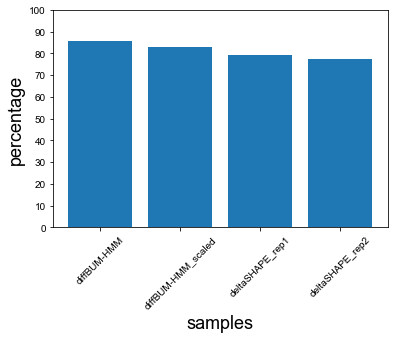

In [34]:
fig,ax = plt.subplots()
x = np.arange(len(names))
y = sspos
ax.bar(x,y)
ax.set_yticks(np.arange(0,101,10))
ax.set_ylabel("percentage",fontsize=18)
ax.set_xlabel("samples",fontsize=18)
ax.set_xticks(np.arange(len(names)))
ax.set_xticklabels(names,rotation=45)
fig.savefig("DRNs_ex_vivo_in_Xist_ssRNA.pdf",dpi=400)